## Sample Notebook comparing MDF and PyTorch model

In [15]:
from torchvision import transforms
from torchvision.io import read_image
import torch
from PIL import Image
import torchvision.models as models
import numpy as np

from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

### Preprocess the input image

In [16]:
def image_loader(loader, image):
    image = loader(image).float()
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

### Load pretrained IMAGENET model

In [17]:
#using a pretrained model
sample_model = models.mobilenet_v3_large(pretrained=True)

#evaluating to get rid of randomization like dropout and batch-normalization
sample_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

### Load Input Image

In [19]:
image_path = "pytorch_example_images/a/img2.jpeg"
input_image = Image.open(image_path)

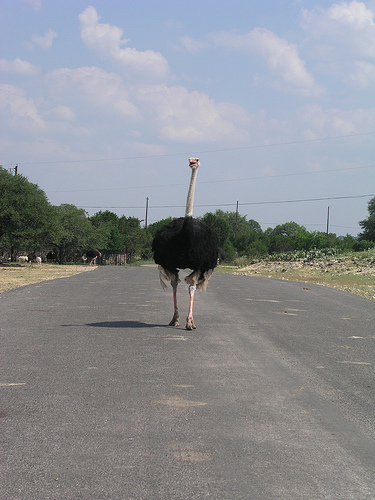

In [20]:
display(input_image)

### load output classes for IMAGENET dataset

In [6]:
import ast
  
# reading the data from the file
with open('imagenet_labels.txt') as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
d = ast.literal_eval(data)
  
print("Data type after reconstruction : ", type(d))
print(d)

Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>
{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common ne

### Pass the input through PyTorch Model

In [8]:
input = image_loader(data_transforms, input_image)
output = sample_model(input).detach().numpy()
op_label = np.argmax(output)
print(d[op_label])

ostrich, Struthio camelus


### Convert PyTorch model to MDF 

In [10]:
mdf_model, params_dict = pytorch_to_mdf(
        model=sample_model,
        args=input,
        trace=True,
    )

### Passing Input through MDF model

In [21]:
mdf_graph = mdf_model.graphs[0]
# mdf_graph_nodes = mdf_graph.nodes[id='Conv_499']
params_dict["input1"] = input.detach().numpy()

eg = EvaluableGraph(graph=mdf_graph, verbose=False)

eg.evaluate(initializer=params_dict)

output_mdf = eg.output_enodes[0].get_output()
op_label_mdf = np.argmax(output_mdf)
print(d[op_label_mdf])


Init graph: MobileNetV3Graph
Evaluating graph: MobileNetV3Graph, root nodes: ['Conv_499'], with array format numpy
ostrich, Struthio camelus


### MDF Graph

Converting MDF graph: MobileNetV3Graph to graphviz (level: 1, format: png)
    Node: Conv_499
    Node: HardSwish_315
    Node: Conv_502
    Node: Relu_318
    Node: Conv_505
    Node: Add_321
    Node: Conv_508
    Node: Relu_324
    Node: Conv_511
    Node: Relu_327
    Node: Conv_514
    Node: Conv_517
    Node: Relu_332
    Node: Conv_520
    Node: Relu_335
    Node: Conv_523
    Node: Add_338
    Node: Conv_526
    Node: Relu_341
    Node: Conv_529
    Node: Relu_344
    Node: GlobalAveragePool_345
    Node: Conv_346
    Node: Relu_347
    Node: Conv_348
    Node: HardSigmoid_349
    Node: Mul_350
    Node: Conv_532
    Node: Conv_535
    Node: Relu_355
    Node: Conv_538
    Node: Relu_358
    Node: GlobalAveragePool_359
    Node: Conv_360
    Node: Relu_361
    Node: Conv_362
    Node: HardSigmoid_363
    Node: Mul_364
    Node: Conv_541
    Node: Add_367
    Node: Conv_544
    Node: Relu_370
    Node: Conv_547
    Node: Relu_373
    Node: GlobalAveragePool_374
    Node: Conv_37

Written graph image to: example.png


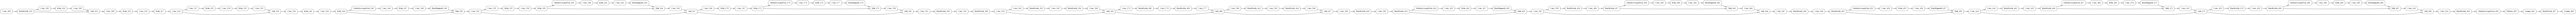

In [12]:
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="example",
    only_warn_on_fail=True,
    is_horizontal = True
)
from IPython.display import Image
Image(filename="example.png")

### ONNX Graph

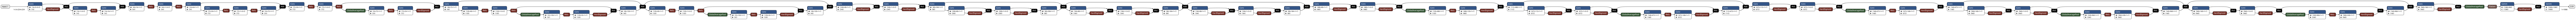

In [13]:
try:
    from IPython.display import Image
    onnx_graph = Image(filename="example.onnx.png")
    display(onnx_graph)
    
except:
    import netron
    torch.onnx.export(
            sample_model,
            input,
            "example.onnx",
            verbose=True,
            input_names=[],
            opset_version=9,
        )
    netron.start("example.onnx")
